## Textual Analysis of Modern British Philosophers
- This is my course project for Digital Humanities course (Fall 17) at University of Georgia with Dr.William Kretzschmar.
- Should be compatible with both Python 2 and 3
- Parts of the codes in this notebook are benefited from this notebook https://github.com/brandomr/document_cluster/blob/master/cluster_analysis_web.ipynb
- Tasks include:
  * keyword plotting and analysis; 
  * Comparison of similarities of books based on TF-IDF (using scikit-learn); 
  * Unsupervised classfication of books; 
  * Prediction of the category of a book based on the aforementioned unsupervised classfication results  
  * LDA analysis; 
  * Sentimental analysis (using textblob)

In [31]:
from __future__ import print_function

try:
    import builtins
except ImportError:
    import __builtin__ as builtins
from __builtin__ import str

In [10]:

from __future__ import unicode_literals
from sklearn import feature_extraction  #For extracting features
import numpy as np    #For basic scientific and numerical calculations
import nltk           #Natural Language ToolKit
import pandas as pd   #For dataframe processing
import re    #For regular expression
import matplotlib.pyplot as plt  #For plotting
# %matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import DictVectorizer
from gensim import corpora, models, similarities
from nltk.tag import pos_tag
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.feature_extraction.text import TfidfTransformer
from textblob import TextBlob
from nltk.corpus import stopwords

In [8]:
# Some Global Variables
AUTHOR_FILES = ['Bentham.txt', 'Berkeley.txt','Hobbes.txt','Hume.txt','Locke.txt', 'Mill.txt', 'Sidgwick.txt'] 
# each txt file contains all searchable works from a single philosopher
NUM_WORDS = 80   # show how many highly frequent words in the plots
MORE_SW = False # whether we want more stop words
BOOK_LIST = ['hobbes-leviathan', 'hobbes-liberty', 'hobbes-elements', 'hobbes-law', 'mill-liberty', 'mill-util','locke-understanding',
             'locke-treatise', 'hume-treatise', 'hume-morals', 'hume-enquiry', 'berkeley-TOK','berkeley-TD', 
             'bentham-POM', 'bentham-FOG', 'mill-representative', #'burke-reflections','conway-nature','mill-comte','more-utopia',
             'reid-mind', 'hume-religion']  # this is the booklist we will analyse. Must be in the same folder
TEST_FILES = ['sidgwick.txt','machiavelli.txt','more-utopia','burke-reflections','smith-sentiments','smith-wealth',
             'fedPapers', 'mill-logic', 'kant-CPR', 'russell-AOM', 'russell-external', 'russell-ideals',
              'russell-mysticism', 'russell-POP', 'spinoza-ethica', 'spinoza-understanding','Shi-PC', 'Shi-equality',
              'Shi-AM', 'Shi-MP']
NUM_CLUSTERS = 6 # how many clusters we want to categorize when we process different individual books.
SENTIMENT_LIST = []

In [9]:
#Adding more stopwords. Providing the option of an aggressive word list.
# nltk.download('stopwords')  #Not necessary if you have done it once
stop_words = list(set(stopwords.words('english')))
stop_words.append('\'s')#manually add 's into the stop word list (because it's annoying!) We may add more similar ones.

if MORE_SW:   #if we want to add more stop words and render a more aggressive stopword list
    with open('stopwords', 'r') as myfile:
        sw = [i.strip().split(' ') for i in myfile]
    sw1 = [val.lower() for sublist in sw for val in sublist]
    stop_words.extend(sw1)
    stop_words = set(stop_words)


In [11]:
def tokenize(text):
    '''
    Tokenize the words in a texts. If we need tokenize and stemming, we can 
    comment this function and uncomment the function below.
    '''
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):  #only search English words and put them into tokens
            filtered_tokens.append(token.lower())
    return (filtered_tokens)

# from nltk.stem.snowball import SnowballStemmer
# nltk.download('punkt')
# stemmer = SnowballStemmer("english")
# def tokenize(text):
#     tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
#     filtered_tokens = []
#     for token in tokens:
#         if re.search('[a-zA-Z]', token):  #only search English words and put them into tokens
#             if token.lower() not in stop_words:
#                 filtered_tokens.append(token.lower())
#     stems = [stemmer.stem(t) for t in filtered_tokens]
#     return stems   # it turns out that stemming may not be a good choice...
    

In [24]:
def word_count(text):
    '''
    Count how many words in an author's work
    '''
    chunk_dict = {}
    for i in text:
        i = i.encode('utf-8', 'ignore').lower()
#         i = str(i).lower() # we only need lower-case of an item in the word_chunk list.
        if i.decode('utf-8', 'ignore') not in stop_words:
            if chunk_dict.get(i.decode('utf-8', 'ignore')) is None:     # we don't need the stopwords
                chunk_dict[i.decode('utf-8', 'ignore')] = 1     
            else:
                chunk_dict[i.decode('utf-8', 'ignore')] += 1

    chunk_dict = sorted(chunk_dict.items(), key=lambda k_v: k_v[1], reverse=True)
    return chunk_dict

# TD_count = word_count(h_tokens)

In [25]:
def plot_wc(wc_list, author_name):
    '''
    Plot the first NUM of words word count list, with the author name
    '''
    wc_plot = dict(wc_list[0:NUM_WORDS])
    plt.figure(num=None, figsize=(96,64), dpi=80, facecolor='w', edgecolor='k')
    plt.bar(range(len(wc_plot)), sorted(wc_plot.values(), reverse=True), align='center')
    plt.xticks(range(len(wc_plot)), wc_plot.keys(), fontsize = 64, rotation=85)
    plt.yticks(fontsize= 72)
    plt.xlabel('Words', fontsize=78)
    plt.ylabel('Occurances', fontsize=78)
#     plt.rcParams["figure.figsize"] = (32,24)
    plt.figtext(.5,.8,'Top ' + str(NUM_WORDS) + ' Words of ' + author_name, fontsize=96,ha='center')
#     plt.show()   # if we want to show the plot
# from here https://stackoverflow.com/questions/11373610/save-matplotlib-file-to-a-directory
    script_dir = os.path.dirname(os.path.abspath('analysis.ipynb'))
    results_dir = os.path.join(script_dir, 'keywordResults/')   
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    plt.savefig(results_dir + author_name , dpi=100)
    plt.close()   # Close the plot save memory

In [26]:
import codecs
def kw_plot(text):
    '''
    Wrapper to process texts for all philosophers
    '''
    with codecs.open('./authorCorpus/' + text, 'r', encoding='utf-8', errors='ignore') as file:
        t = file.read()
    author = (str(text)[:-4])
    t_tokens = tokenize(t)
    t_count = word_count(t_tokens)
    t_plot = plot_wc(t_count, author)
    return t_plot

In [27]:
for f in AUTHOR_FILES:
    print ('Processing ' + str(f) + '...')  # 
    %time kw_plot(f) 
print ("Done!")

Processing Bentham.txt...
CPU times: user 20 s, sys: 430 ms, total: 20.5 s
Wall time: 21.1 s
Processing Berkeley.txt...
CPU times: user 17.5 s, sys: 408 ms, total: 17.9 s
Wall time: 18.3 s
Processing Hobbes.txt...
CPU times: user 33.8 s, sys: 710 ms, total: 34.5 s
Wall time: 35.5 s
Processing Hume.txt...
CPU times: user 26.8 s, sys: 658 ms, total: 27.5 s
Wall time: 28.4 s
Processing Locke.txt...
CPU times: user 18.6 s, sys: 434 ms, total: 19.1 s
Wall time: 19.8 s
Processing Mill.txt...
CPU times: user 25.4 s, sys: 466 ms, total: 25.9 s
Wall time: 26.1 s
Processing Sidgwick.txt...
CPU times: user 16.3 s, sys: 331 ms, total: 16.7 s
Wall time: 16.8 s
Done!


In [9]:
def read_book(booklist):
    read = []  # array to store processed individual books
    for b in booklist:
        with codecs.open('./authorBooks/' + b, 'r', encoding='utf-8', errors='ignore') as file:
#         with open('./authorBooks/' + b, 'r') as myfile:
            book_file = file.read()
        read.append(book_file)
    return read

book_str_list = []
# BOOK_LIST.extend(TEST_FILES)  #Optional! Just for fun!
book_str_list = read_book(BOOK_LIST)
print ('We are analyzing '+ str(len(book_str_list)) + ' books!') #Check whether if it's good

We are analyzing 18 books!


In [10]:
def process_books(str_list):
    total_words = []
    # Put all the tokenized words in a list
    for i in book_str_list:
        allwords_tokenized = tokenize(i)
        total_words.extend(allwords_tokenized)
    #define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=1000000, min_df=0.1, stop_words=stop_words, 
                                       use_idf=True, tokenizer=tokenize, ngram_range=(1,2))

    print ('Processing Time:')
    tfidf_matrix = tfidf_vectorizer.fit_transform(str_list) 
    print ('Now we have a matrix with the shape of' + str(tfidf_matrix.shape))
    feature_terms = tfidf_vectorizer.get_feature_names()
    tokenized_v_frame = pd.DataFrame({'words': total_words}, index = total_words)
    return total_words, tfidf_matrix, feature_terms, tokenized_v_frame

%time totalvocab_tokenized, tfidf_matrix, key_terms, vocab_frame = process_books(book_str_list)

Processing Time:
Now we have a matrix with the shape of(18, 78463)
CPU times: user 46.1 s, sys: 488 ms, total: 46.6 s
Wall time: 46.7 s


In [28]:
def kmcluster(matrix):
    '''
    Unsupervised learning by using KMeans from sklearn; return a list of cluster indexes
    '''
    km = KMeans(n_clusters=NUM_CLUSTERS, n_init = 60, max_iter=700, verbose = 0)
    %time km.fit(matrix)
    cluster_idx = km.labels_.tolist()
    centroids = km.cluster_centers_.argsort()[:, ::-1]   #Finding the centroids
    return cluster_idx, centroids

clusters, order_centroids = kmcluster(tfidf_matrix)
print (clusters)

CPU times: user 44.3 s, sys: 977 ms, total: 45.3 s
Wall time: 23.8 s
[0, 5, 4, 0, 1, 1, 3, 0, 2, 2, 2, 3, 3, 1, 1, 1, 3, 2]


In [35]:
def gen_frame(blist, c):
    '''
    Generate a pandas data frame for the categorized results. 
    Two arguments are book list containing only names, and assigned cluster categories.
    '''
    cat = {'book_title': blist, "cluster":c}     # Dictionary for categories
    frame = pd.DataFrame(cat, columns = ['book_title', 'cluster']) # put the dict above into a dataframe
    return frame

frame = gen_frame(BOOK_LIST, clusters)
frame.sort_values('cluster')

,book_title,cluster
0,hobbes-leviathan,0
3,hobbes-law,0
7,locke-treatise,0
15,mill-representative,1
14,bentham-FOG,1
4,mill-liberty,1
5,mill-util,1
13,bentham-POM,1
10,hume-enquiry,2
8,hume-treatise,2


In [29]:

def top_term(v_f, terms, centroids):
    print("Top terms per cluster: \n")
    tmp_dict = defaultdict(list)   #temporary dictionary that appends top terms per cluster 
    for i in range(NUM_CLUSTERS):
        print("Cluster %d words:" % i, end = '')
        for ind in centroids[i, :20]: #replace 60 with n words per cluster
            if str(v_f.ix[terms[ind].split(' ')].values.tolist()[0][0]) != 'nan': #get rid of extra 'nan' words
                print (' %s' % v_f.loc[terms[ind].split(' ')].values.tolist()[0][0], end =',')
#                 yield v_f.ix[terms[ind].split(' ')].values.tolist()[0][0]
                tmp_dict[i].append(v_f.loc[terms[ind].split(' ')].values.tolist()[0][0]) 
        print('\n') #add whitespace
    return tmp_dict

cluster_dict = top_term(vocab_frame, key_terms, order_centroids)


Top terms per cluster: 

Cluster 0 words: hath, sovereign, adam, christ, government, commonwealth, covenant, father, dominion, children, king, unto, civil, sovereignty, war, every, saviour, law, moses, amongst,

Cluster 1 words: government, society, public, utilitarian, happiness, moral, offences, conduct, interest, political, utility, social, duty, however, class, character, punishment, morality, interests, institutions,

Cluster 2 words: idea, ideas, cleanthes, sentiment, causes, reasoning, society, philo, passions, sentiments, entirely, philosophy, moral, species, existence, influence, connexion, project, gutenberg-tm, passion,

Cluster 3 words: ideas, phil, idea, exist, motion, existence, sensation, perceived, bodies, extension, sensations, hath, without, substance, sensible, colour, visible, distance, shape, human,

Cluster 4 words: b, c, f, e, strait, g, h, b, motion, line, k, angle, arch, lines, e, n, wherefore, moved, superficies, b,

Cluster 5 words: lordship, hath, election, 

In [30]:
def cos_dist(matrix):
    return 1 - cosine_similarity(matrix)

dist = cos_dist(tfidf_matrix)

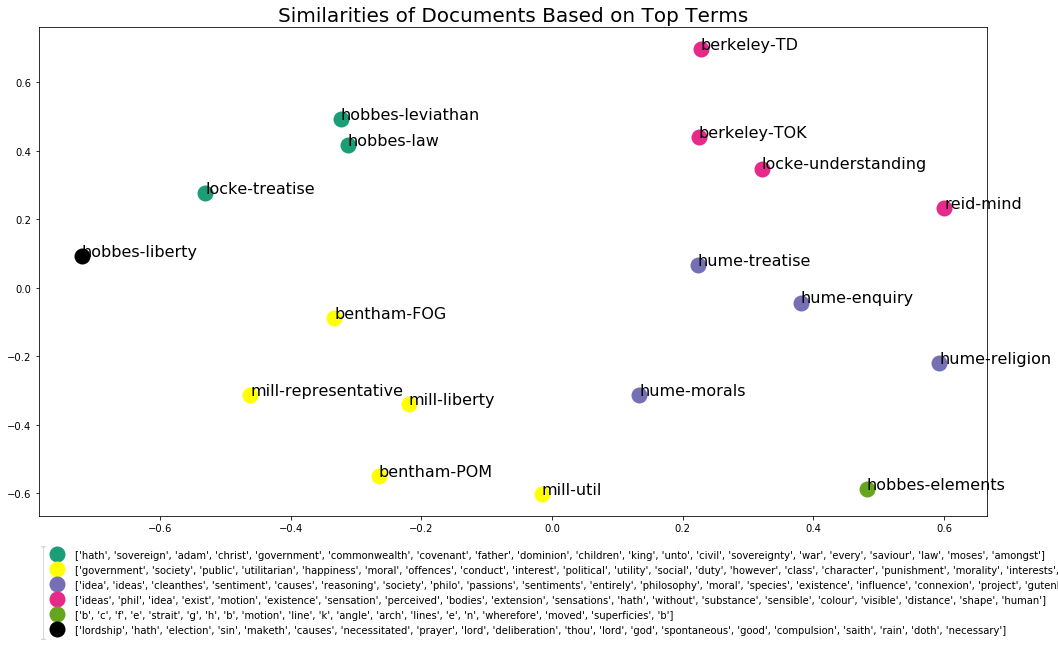

In [31]:
%matplotlib inline
# MDS()
def plot_similarity(clusters, plotlist, word_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=plotlist)) 
    #group by cluster
    groups = df.groupby('label')
    # print (df)
    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    cluster_colors = {0: '#1b9e77', 1: '#ffff00', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:'#000000'} # for plotting
#     ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=16, label=cluster_dict[name], color=cluster_colors[name], 
                mec='none')
        ax.set_aspect('auto')

    ax.legend(numpoints=1, loc = 8, bbox_to_anchor=(0.005, -0.25), borderaxespad=0., mode = 'expand')  #show legend with only 1 point
    ax.set_title('Similarities of Documents Based on Top Terms', fontdict={'fontsize': 20})
    #add label in x,y position with the label as the book title
    for i in range(len(df)):
        ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=16)  
    return plt.show() #show the plot

plot_similarity(clusters, BOOK_LIST, tfidf_matrix)

(17, 4)


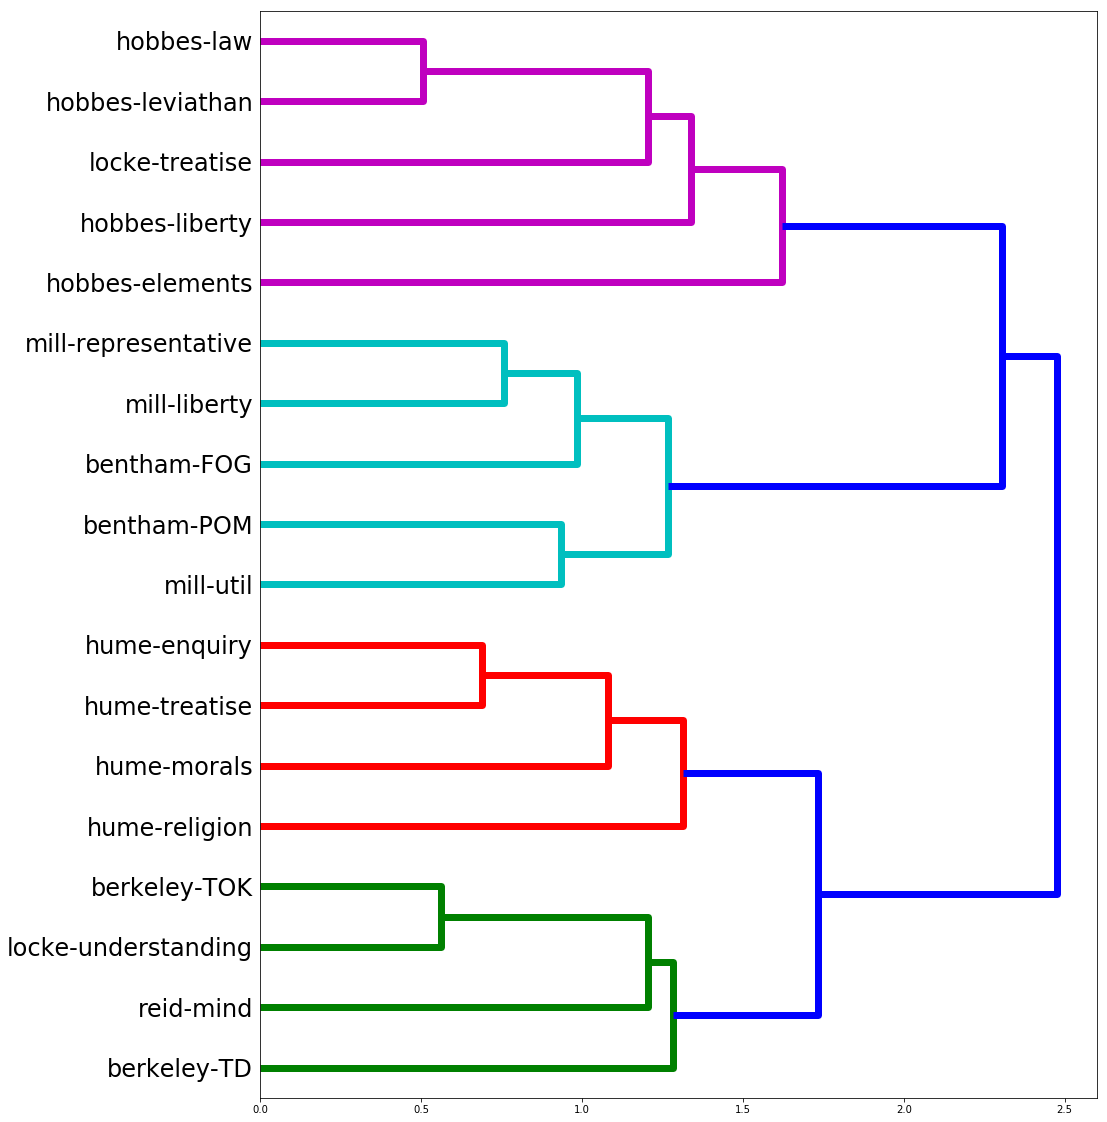

In [34]:

import matplotlib
%matplotlib inline
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
print (linkage_matrix.shape) 
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=BOOK_LIST, leaf_font_size = 24);

matplotlib.rcParams['lines.linewidth'] = 6

#uncomment below to save figure
plt.savefig('ward_clusters_1208.png', dpi=200, figsize=(15, 20)) #save figure as ward_clusters
plt.show()
# plt.close()

In [36]:
def train_test_clf(train_str_list, test_list):
    '''
    Train a Naive Bayes Classifier based on word counts in the training string set
    '''
    count_vect = CountVectorizer(tokenizer=tokenize, lowercase=False, stop_words = stop_words)
    train_counts = count_vect.fit_transform(train_str_list)
    tfidf_transformer = TfidfTransformer()
    train_matrix = tfidf_transformer.fit_transform(train_counts)
    clf = MultinomialNB().fit(train_counts, clusters)
    docs_new = []
    for b in test_list:
         with codecs.open('./authorBooks/' + b, 'r', encoding='utf-8', errors='ignore') as file:
            docs_new.append(file.read())
            
    doc_new_counts = count_vect.transform(docs_new)
    doc_new_tfidf = tfidf_transformer.transform(doc_new_counts)
    clf_result = clf.predict(doc_new_tfidf)
#     print (clf_result)
    frame_1 = gen_frame(BOOK_LIST, clusters)
    frame_2 = gen_frame(test_list, clf_result)
#     print (clusters, "\n", frame_1, '\n', frame_2)
    res_frame = pd.concat([frame_1, frame_2])
    return clf_result, res_frame

predicted, new_frame = train_test_clf(book_str_list, TEST_FILES)
new_frame.sort_values('cluster')  # Sorting Values

,book_title,cluster
0,hobbes-leviathan,0
3,hobbes-law,0
7,locke-treatise,0
1,machiavelli.txt,0
2,more-utopia,1
3,burke-reflections,1
4,smith-sentiments,1
5,smith-wealth,1
6,fedPapers,1
7,mill-logic,1


In [19]:
nltk.download('averaged_perceptron_tagger')

### Using LDA for Topic Modeling


def strip_propper(text):
    '''
    POS Tagging
    '''
    tagged = pos_tag(text.split())
    non_pnouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_pnouns

preprocess = [strip_propper(doc) for doc in book_str_list]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yuanmingshi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [20]:
def tag_tokenize(text):
    '''
    Another Tokenizer (but used after POS tagging)
    '''
#     tokens = [nltk.word_tokenize(word) for word in text]
    filtered_tokens = []
    for token in text:
        if re.search('[a-zA-Z]', token):  #only search English words and put them into tokens
            token = re.sub("[^a-zA-Z]", "", token)
            filtered_tokens.append(token.lower())
    return (filtered_tokens)

%time tokenized_text = [tag_tokenize(text) for text in preprocess]
%time texts = [[word for word in text if word not in stop_words] for text in tokenized_text]

CPU times: user 4.67 s, sys: 85.5 ms, total: 4.76 s
Wall time: 4.78 s
CPU times: user 3.14 s, sys: 20.4 ms, total: 3.16 s
Wall time: 3.18 s


In [21]:
def lda_model(text):

    dictionary = corpora.Dictionary(text)
    dictionary.filter_extremes(no_below = 1, no_above = 0.9)
    corpus = [dictionary.doc2bow(t) for t in text]
    lda = models.LdaModel(corpus, num_topics=6,id2word=dictionary,update_every=6,chunksize=10000,passes=100)
    return lda

%time lda = lda_model(texts)   #build lda model
lda.show_topics()
lda.num_topics

CPU times: user 12min 27s, sys: 10.9 s, total: 12min 38s
Wall time: 8min 4s


6

In [22]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
print (topics_matrix[1])
# topics_matrix = np.array(topics_matrix)
topic_words = []
# topic_words = topics_matrix[:,:,1]
for i,j in topics_matrix:
    topic_words.append([])
    for k,l in j:
        topic_words[i].append(str(k))

for i in topic_words:
    print (i)
    print ()

(1, [('hath', 0.0097186214343891065), ('sovereign', 0.0076156109557268311), ('government', 0.0063507356423933448), ('commonwealth', 0.0062614354845635092), ('civil', 0.0045189306970585836), ('children', 0.004281274829151434), ('king', 0.0040511136961598124), ('war', 0.0036549089944608666), ('kingdom', 0.0034393164320635221), ('subjects', 0.0033342804481569311), ('dominion', 0.0033235745978065466), ('obedience', 0.0031572208872509412), ('public', 0.0031058108587943833), ('father', 0.0030757345161975956), ('amongst', 0.0030334832591681722), ('society', 0.0029995422799485409), ('private', 0.0029370647038409782), ('unto', 0.0029211500069295146), ('peace', 0.0029075344438180182), ('honour', 0.0028469374474443449)])
['ideas', 'idea', 'motion', 'existence', 'complex', 'bodies', 'species', 'exist', 'substances', 'substance', 'perceived', 'sensible', 'hath', 'extension', 'propositions', 'space', 'wherein', 'innate', 'duration', 'sort']

['hath', 'sovereign', 'government', 'commonwealth', 'civil

,book_title,Polarity,Subjectivity
0,hobbes-leviathan,0.091606,0.467074
1,hobbes-liberty,0.119379,0.511645
2,hobbes-elements,0.049233,0.368463
3,hobbes-law,0.093053,0.451258
4,mill-liberty,0.112755,0.489526
5,mill-util,0.136673,0.480974
6,locke-understanding,0.106124,0.464916
7,locke-treatise,0.128269,0.501834
8,hume-treatise,0.094186,0.464604
9,hume-morals,0.119711,0.471109


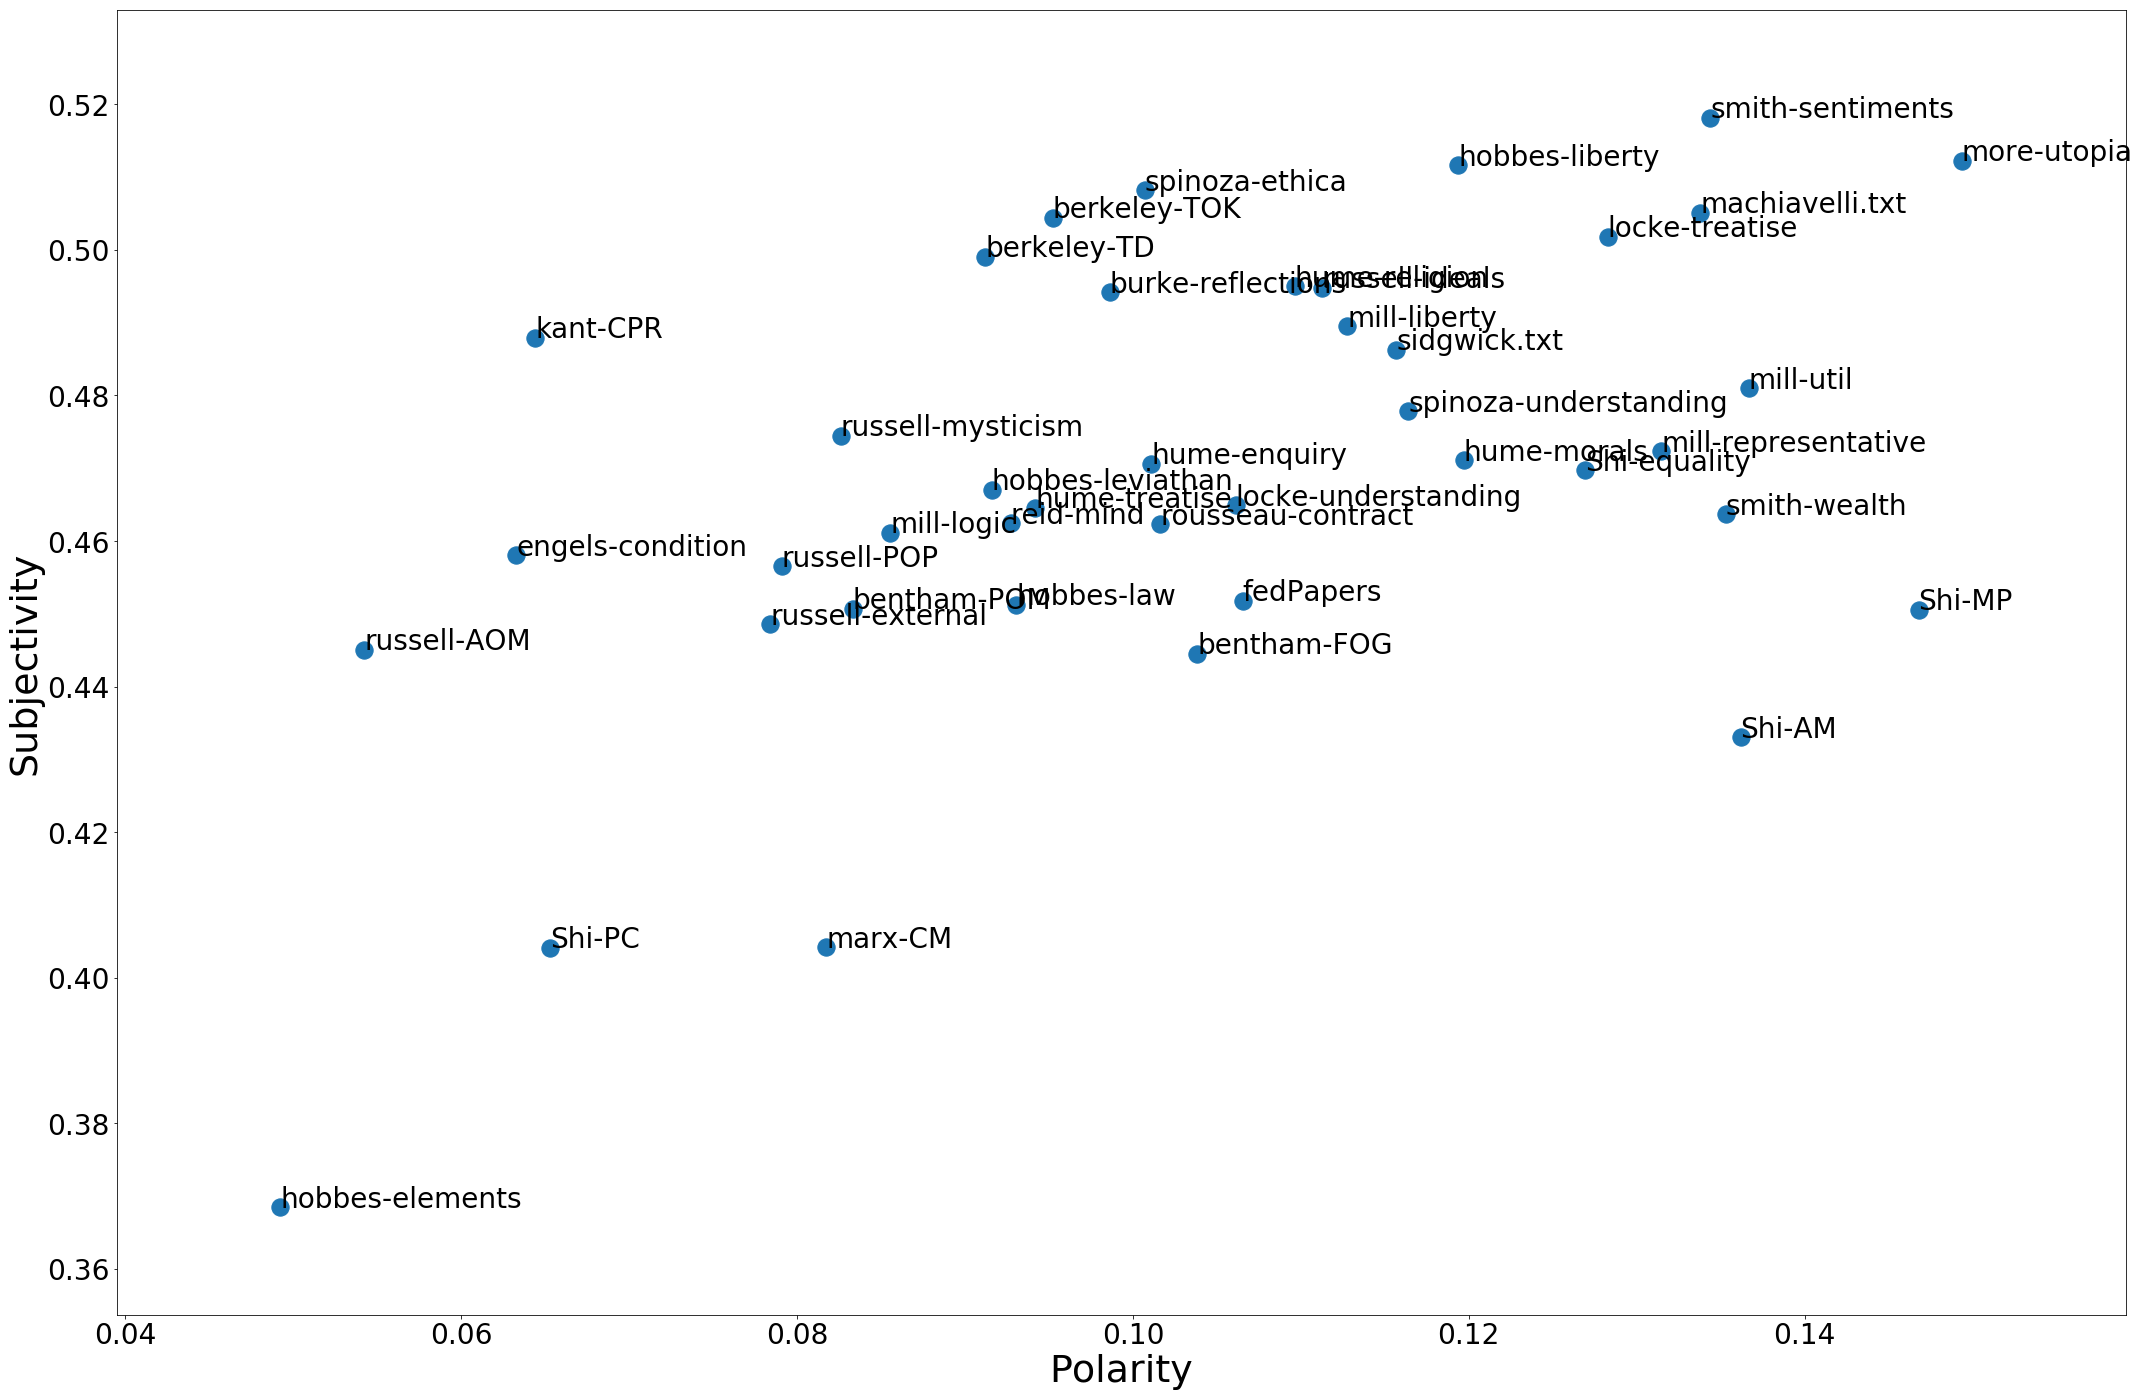

In [37]:
from matplotlib import cm
def pol_sub(title_list):
    '''
    Polarization and Subjectivity Analysis. Just for fun!
    '''
    book_s_list = read_book(title_list)
    df_dict = {'book_title': title_list, 'Polarity':[TextBlob(book).sentiment.polarity for book in book_s_list], 
               'Subjectivity': [TextBlob(book).sentiment.subjectivity for book in book_s_list]}
    res_df = pd.DataFrame(df_dict, columns = ['book_title', 'Polarity', 'Subjectivity'])
    ax = res_df.plot.scatter('Polarity', 'Subjectivity', figsize = (36,24),  style=['o', 'rx'], fontsize = 28,
                             s=300)
    matplotlib.rcParams.update({'font.size': 28, 'axes.labelsize' : 46})
    res_df[['Polarity', 'Subjectivity','book_title']].apply(lambda x: ax.text(*x, fontsize=28),axis=1);
    
    return res_df
if SENTIMENT_LIST == []:
    # Testing the files we have already
    SENTIMENT_LIST = list(BOOK_LIST)
    SENTIMENT_LIST.extend(TEST_FILES)
    SENTIMENT_LIST.extend(['rousseau-contract', 'engels-condition','marx-CM'])
pol_sub(SENTIMENT_LIST)    



## Appendix
* Here is the appendix
 - Stopwords

In [24]:
print (stop_words)

['doesn', 'did', 'then', 'i', 'it', 'do', 'm', 'these', 'such', 'was', 'can', 'hasn', 'your', 'herself', 'a', 'than', 'they', 'been', 'where', 'shan', 'does', 'doing', 'we', 'have', 'up', 'against', 'during', 'yourself', 'haven', 'in', 'too', 'by', 'each', 'whom', 'themselves', 'now', 'through', 'further', 'll', 'had', 'me', 'before', 'after', 'some', 'wouldn', 'he', 'her', 'no', 'most', 't', 'its', 'and', 'ourselves', 'o', 'itself', 'why', 'down', 'the', 'but', 'that', 'being', 'from', 'of', 'isn', 'myself', 'shouldn', 'weren', 'not', 'with', 'am', 'which', 'or', 'when', 'd', 'into', 'over', 'mustn', 'ain', 'you', 'at', 'wasn', 'nor', 'just', 'few', 'other', 'our', 'here', 'under', 'any', 'this', 'is', 'aren', 'same', 's', 'there', 'to', 'my', 'yours', 'should', 'won', 'ours', 'what', 'for', 'couldn', 'hers', 'more', 'having', 'didn', 'his', 'once', 've', 'below', 'about', 'hadn', 're', 'if', 'be', 'out', 'so', 'an', 'only', 'will', 'are', 'mightn', 'needn', 'off', 'has', 'while', 'ab

In [ ]:
#Helper Function to get rid of all the copyright info.

import os, fnmatch
def findReplace(directory, find, replace, filePattern):
    for path, dirs, files in os.walk(os.path.abspath(directory)):
        for filename in fnmatch.filter(files, filePattern):
            filepath = os.path.join(path, filename)
            with open(filepath) as f:
                s = f.read()
            s = s.replace(find, replace)
            with open(filepath, "w") as f:
                f.write(s)